# Sample Simulation: Talk of the Town

This notebook contains a reimplementation of the Talk of the town simulation in Neighborly. You can find the originial Talk of the Town implementation [here](https://github.com/james-owen-ryan/talktown).

It simulates a single town and characters engage in generally mundane behavior such as being born, growing up, going to school, working jobs, finding romance, and having families. Since Talk of the Town's content comes bundled with neighborly, we don't need to define any additional content within this notebook.

In [1]:
from __future__ import annotations

import time
import math
from typing import Dict, Any

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from neighborly.config import NeighborlyConfig
from neighborly.simulation import Neighborly
from neighborly.core.ecs import World, Active, SystemBase
from neighborly.core.time import HOURS_PER_YEAR
from neighborly.data_collection import DataCollector
from neighborly.components.character import GameCharacter
from neighborly.core.time import SimDateTime

# Create the simulation

In [2]:
sim = Neighborly(
    NeighborlyConfig.parse_obj(
        {
            "plugins": [
                "neighborly.plugins.defaults.all",
                "neighborly.plugins.talktown",
            ],
            "logging": {
                "logging_enabled": False,
                "log_level": "DEBUG",
            },
            "settings": {
                "settlement_size": (5, 5),  # Width/length of the settlement grid
                "zoning": (0.5, 0.5),  # Zoning is 50/50 residential vs. commercial
                "character_spawn_table": [
                    {"name": "character::default::male"},
                    {"name": "character::default::female"},
                    {"name": "character::default::non-binary"},
                ],
                "residence_spawn_table": [
                    {"name": "residence::default::house"},
                ],
                "business_spawn_table": [],
            },
        }
    )
)

## Tracking Population Size

A simple system to create is one that tracks the population size each year. We define it as an ECS system that runs during the early-update phase of a simulation step and counts the number of active characters in the simulation

In [3]:
class TrackPopulation(SystemBase):
    def __init__(self) -> None:
        super().__init__()
        self.last_recorded_year = 0

    def on_create(self, world):
        data_collector = world.resource_manager.get_resource(DataCollector)
        data_collector.create_new_table("population", ("timestamp", "population"))

    def on_update(self, world):
        data_collector = world.resource_manager.get_resource(DataCollector)
        current_date = world.resource_manager.get_resource(SimDateTime)

        if current_date.year > self.last_recorded_year:
            population = len(world.get_components((Active, GameCharacter)))
            data_collector.add_table_row(
                "population", {"timestamp": current_date.year, "population": population}
            )
            self.last_recorded_year = current_date.year

In [4]:
from neighborly.systems import DataCollectionSystemGroup
from tqdm.notebook import trange

sim.world.system_manager.add_system(
    TrackPopulation(), system_group=DataCollectionSystemGroup
)

YEARS = 150

for _ in trange(YEARS):
    sim.step()

  0%|          | 0/150 [00:00<?, ?it/s]

## Data visualization

In [5]:
import matplotlib.pyplot as plt

%matplotlib inline

Text(0.5, 1.0, 'Population of Simulation (seed: 4128541)')

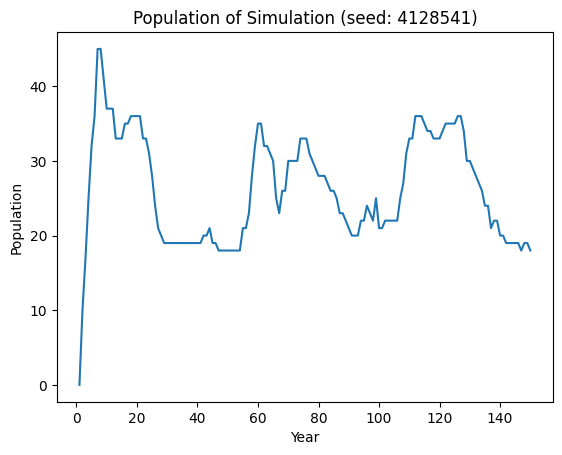

In [6]:
population_table = sim.world.resource_manager.get_resource(
    DataCollector
).get_table_dataframe("population")

plt.plot(
    population_table["timestamp"],
    population_table["population"],
)
plt.xlabel("Year")
plt.ylabel("Population")
plt.title(f"Population of Simulation (seed: {sim.config.seed})")